## Simulation code

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random as rnd
from tqdm import tqdm

__location__ = os.path.realpath(os.getcwd())

print(__location__)
def target_height_to_box_dim_RDG6(target_height, target_height_is_in_cells=False):
    '''Returns cell width, depth, height given target height'''
    if target_height_is_in_cells:
        target_height *= np.sqrt(6)/3

    return round(target_height*2), round(target_height*4*np.sqrt(3)/3), round(target_height*3/np.sqrt(6))

def boxdim_to_real_distance_RDG6(dims):
    '''Returns real distance given box dimensions'''
    return (dims[0], dims[1]*3/(2*np.sqrt(3)), dims[2]*np.sqrt(6)/3)

class DBM_RDG:

    def __init__(self,
                 target_height=None,
                 nu=1.5,
                 debug=False,
                 threshold = 0.0001,
                 dim_info=False):
        
        cell_dims = target_height_to_box_dim_RDG6(target_height)
        self.dim = {'width': cell_dims[0], 'depth': cell_dims[1], 'height': cell_dims[2]}

        # calculating number of cells needed to create target dimensions
        x_needed = self.dim['width']*2+1
        y_needed = self.dim['depth']*3//2
        z_needed = self.dim['height']+2
        self.needed_cell_dim = {'width': x_needed, 'depth': y_needed, 'height': z_needed}

        # Create encoding grid and set all to 0
        #  0 encodes unfixed potential
        #  anything else encodes fixed potential
        # (I also use this grid to track order of cells in lightning structure)
        self.fixed_grid = np.zeros(shape=(x_needed, y_needed, z_needed))
        
        # Calculate effective width and depth given inputted dimensions
        # effective_width = self.dim['width']//2+1
        # y_pos_cells = self.dim['depth']*2//3
        # effective_depth = y_pos_cells * np.sqrt(3)/2
        # diff = int(effective_depth - effective_width)
        # effective_width += diff
        
        if dim_info:
            print("# cells in x:", self.dim['width'])
            print("# cells in y:", self.dim['depth'])
            print("# cells in z:", self.dim['height'])
            real_dist_dims = boxdim_to_real_distance_RDG6((self.dim['width'], self.dim['depth'], self.dim['height']))
            print("Effective width (x-pos):", real_dist_dims[0])
            print("Effective depth (y-pos):", real_dist_dims[1])
            print("Effective height (z-pos):", real_dist_dims[2])
        
        
        self.upwards_neighbors = [(0,0,1),(0,1,1),(1,1,1)]
        
        # Set all boundaries to be fixed
        
        # top & bottom boundary
        for x_pos in range(self.dim['width']+2):
            for y_pos in range(self.dim['depth']+2):
                self.fixed_grid[(x_pos)+(y_pos)//2, (y_pos), 0] = -1
                try:
                    self.fixed_grid[(x_pos)+(y_pos-3)//2 + self.dim['width']//6, (y_pos-3) + self.dim['width']//3+1, self.dim['height']-1] = -1
                except:
                    ...
        
        # right boundary
        y_pos = 0
        current_pos = [0,0,0]
        while y_pos < self.dim['depth']+1:
            current_pos = [y_pos//2, y_pos, 0]
            self.fixed_grid[current_pos[0], current_pos[1], current_pos[2]] = -1
            y_pos += 1
            
            z_pos = 0
            current_z_pos = np.array(current_pos[:])
            while z_pos < self.dim['height']:
                self.fixed_grid[current_z_pos[0], current_z_pos[1], current_z_pos[2]] = -1
                current_z_pos += np.array(self.upwards_neighbors[z_pos%3])
                z_pos += 1
            
        # left boundary
        y_pos = 0
        while y_pos < self.dim['depth']+1:
            current_pos = [self.dim['width']+1+y_pos//2, y_pos, 0]
            self.fixed_grid[current_pos[0], current_pos[1], current_pos[2]] = -1
            y_pos += 1
            
            z_pos = 0
            current_z_pos = np.array(current_pos[:])
            while z_pos < self.dim['height']:
                try:
                    self.fixed_grid[current_z_pos[0], current_z_pos[1], current_z_pos[2]] = -1
                except:
                    ...
                current_z_pos += np.array(self.upwards_neighbors[z_pos%3])
                z_pos += 1
            
        # front boundary
        x_pos = 0
        while x_pos < self.dim['width']+1: #(self.dim['width']//2+2):
            current_pos = [x_pos, 0, 0]
            self.fixed_grid[current_pos[0], current_pos[1], current_pos[2]] = -1
            x_pos += 1
            
            z_pos = 0
            current_z_pos = np.array(current_pos[:])
            while z_pos < self.dim['height']:
                self.fixed_grid[current_z_pos[0], current_z_pos[1], current_z_pos[2]] = -1
                current_z_pos += np.array(self.upwards_neighbors[z_pos%3])
                z_pos += 1
            
        # back boundary
        x_pos = 0
        while x_pos < self.dim['width']+1: #(self.dim['width']//2+2):
            current_pos = [(self.dim['depth']+1)//2+x_pos, self.dim['depth']+1,0]
            self.fixed_grid[current_pos[0], current_pos[1], current_pos[2]] = -1
            x_pos += 1
            
            z_pos = 0
            current_z_pos = np.array(current_pos[:])
            while z_pos < self.dim['height']:
                try:
                    self.fixed_grid[current_z_pos[0], current_z_pos[1], current_z_pos[2]] = -1
                except:
                    ...
                current_z_pos += np.array(self.upwards_neighbors[z_pos%3])
                z_pos += 1
            

        # The electric potential
        self.potential = np.zeros(shape=(x_needed, y_needed, z_needed))

        # The lightning downwards-tendency parameter
        self.nu = nu

        # Number of update steps
        self.steps = 1

        # To debug or not
        self.debug = debug

        # Keep track of current neighbors of structure
        self.structure_neighbors = set()

        self.struck_ground = False

        self.threshold = threshold

        # Debugging lists
        self.difference_per_conv = []
        self.overall_sum = []
        
        self.structure_history = []
        
        self.dist_to_ground = self.dim['height']

        # RDG Neighborhood
        self.neighbors = [(0,0,0), (0,1,0), (0,-1,0), (1,0,0), (1,1,0), (-1,0,0), (-1,-1,0),
                                      (0,0,1),(0,1,1),(1,1,1), 
                                      (0,0,-1),(0,-1,-1),(-1,-1,-1)]
        
        # Setup initial electric potential
        self.initial_electric_pot()

        # Add the first cell as a structure neighbor
        self.structure_neighbors.add((self.dim['width']//2 + self.dim['depth']//4, self.dim['depth']//2, 0))
        
        # Update structure with that cell
        self.expand_lightning_to((self.dim['width']//2 + self.dim['depth']//4, self.dim['depth']//2, 0))
        
        self.steps += 1
               
    # Could remove this
    def get_neighbors(self, pos):
        
        neighbors = []
        
        for neighbor_rel in self.neighbors:
            neighbors.append((pos[0]+neighbor_rel[0], pos[1]+neighbor_rel[1], pos[2]+neighbor_rel[2]))

        
        return neighbors


    def strike_lightning(self):

        # Run update until lightning strikes ground
        self.struck_ground = False

        # Create a tqdm tracker
        if self.debug:
            progress_bar = tqdm(total=self.dim['height'], desc="How close the lightning is to the ground", unit="iter")

        while not self.struck_ground:
            # Update lightning
            self.update()

            if self.debug:
                # If the newly added cell made the lightning stretch one step lower, update dist_to_ground
                if self.dim['height'] - self.newest_neighbor[2] < self.dist_to_ground:
                    self.dist_to_ground = self.dim['height'] - self.newest_neighbor[2]
                    progress_bar.update(1)

    def update(self):

        weights = []
        # For each structure neighbor
        for neighbor_pos in self.structure_neighbors:
            # Raise each weight to the power of nu
            weights.append(self.potential[neighbor_pos[0], neighbor_pos[1], neighbor_pos[2]] ** self.nu)
        
        # Choose a random neighbor with the weighting
        chosen_cell = rnd.choices(list(self.structure_neighbors), weights)[0]

        # Update lightning grid, potential and newest neighbor
        self.expand_lightning_to(chosen_cell)

        self.steps += 1

    def initial_electric_pot(self):
        # Create a linear gradient along the depth axis
        gradient = np.linspace(0, 1, self.needed_cell_dim['height'])[np.newaxis, np.newaxis, :]
        #gradient = np.linspace(0, 0, self.dim['width'])[:, np.newaxis, np.newaxis]

        # Apply the gradient to the array
        self.potential += gradient


    def expand_lightning_to(self, pos):
        '''
        Updates corresponding grids
        Update neighborhood of lightning structure
        Call method to update electric potential
        '''

        self.newest_neighbor = pos
        
        self.structure_history.append(pos)

        # Remove the potential
        self.potential[pos[0], pos[1], pos[2]] = 0
        #self.potential[pos[0], pos[1], pos[2]] = 1

        # Set it as a fixed cell
        self.fixed_grid[pos[0], pos[1], pos[2]] = self.steps

        # Update structure neighbors
        self.structure_neighbors.remove(pos)
        for neighbor_pos in self.get_neighbors(pos):
            if neighbor_pos[2] == self.dim['height']:
                self.struck_ground = True
                break

            if neighbor_pos[0] >= 0 and neighbor_pos[0] < self.needed_cell_dim['width'] and \
                neighbor_pos[1] >= 0 and neighbor_pos[1] < self.needed_cell_dim['depth'] and \
                neighbor_pos[2] >= 0 and neighbor_pos[2] < self.needed_cell_dim['height'] and \
                self.potential[neighbor_pos[0], neighbor_pos[1], neighbor_pos[2]] != 0:
                    self.structure_neighbors.add(neighbor_pos)

        if not self.struck_ground:
            # Update the rest of the potential
            self.potential = self.update_electric_potential()


    def update_electric_potential(self):
        '''
        Uses iterative diffusion to estimate solution to Laplace equation.
        Tracks percentual change for each cell after each diffusion, 
        terminates when the largest percentual change is less than threshold
        '''

        # Make ground and lightning structure fixed
        no_change_mask = self.fixed_grid != 0


        old_potential = np.copy(self.potential)
        new_potential = np.copy(old_potential)

        itr = 0
        # Until threshold
        while True:

            neighbor_avgs = np.zeros_like(new_potential)
            
            # Set each cell to the average in each direction from self.neighbors
            for neighbor in self.neighbors:
                neighbor_avgs += np.roll(new_potential, neighbor, axis=(0,1,2))
            # Divide by the number of neighbors
            neighbor_avgs /= len(self.neighbors)

            new_potential = neighbor_avgs

            # Reset the cells that shouldn't change
            new_potential[no_change_mask] = self.potential[no_change_mask]

            if self.debug:
                self.difference_per_conv.append(np.sum(abs(np.array(new_potential) - np.array(old_potential))))
                self.overall_sum.append(np.sum(np.array(new_potential)))
            
            # percentual change relative to previous iteration
            rel_differences = np.divide(abs(np.array(new_potential) - np.array(old_potential)),np.array(old_potential), out=np.zeros(old_potential.shape, dtype=float), where=old_potential!=0)

            # Terminate when max percentual change is small (below threshold)
            if np.nanmax(rel_differences) < self.threshold:
                break

            old_potential = np.copy(new_potential)
            
        return new_potential

C:\Users\admin\Desktop\Capstone


In [2]:
target_height=10
nu=6
threshold=0.001
sim_instance = DBM_RDG(target_height=target_height, nu=nu, threshold=threshold, dim_info=True)
sim_instance.strike_lightning()

# cells in x: 20
# cells in y: 23
# cells in z: 12
Effective width (x-pos): 20
Effective depth (y-pos): 19.91858428704209
Effective height (z-pos): 9.797958971132712


In [4]:
import cProfile
target_height=15
nu=6
threshold=0.001
sim_instance = DBM_RDG(target_height=target_height, nu=nu, threshold=threshold, dim_info=True)
cProfile.run("sim_instance.strike_lightning()")

# cells in x: 30
# cells in y: 35
# cells in z: 18
Effective width (x-pos): 30
Effective depth (y-pos): 30.310889132455355
Effective height (z-pos): 14.696938456699067
         86528 function calls in 2.395 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       23    0.000    0.000    0.000    0.000 1040871997.py:186(get_neighbors)
        1    0.000    0.000    2.395    2.395 1040871997.py:197(strike_lightning)
       23    0.003    0.000    2.395    0.104 1040871997.py:216(update)
       23    0.016    0.001    2.390    0.104 1040871997.py:241(expand_lightning_to)
       22    0.899    0.041    2.374    0.108 1040871997.py:277(update_electric_potential)
        1    0.000    0.000    2.395    2.395 <string>:1(<module>)
      636    0.000    0.000    0.000    0.000 _function_base_impl.py:894(_copy_dispatcher)
      636    0.001    0.000    0.070    0.000 _function_base_impl.py:898(copy)
      614    0.002    0.000    0.012

## Gather data

In [5]:
# --- Simulation parameters ---
target_height = 30
nu=6
threshold=0.001
target_height_is_in_cells = True
# -----------------------------

width_in_cells, depth_in_cells, height_in_cells = target_height_to_box_dim_RDG6(target_height, target_height_is_in_cells)

real_dist_dims = boxdim_to_real_distance_RDG6((width_in_cells, depth_in_cells, height_in_cells))
import os
print(f"RDG6: {width_in_cells}x{depth_in_cells}x{height_in_cells}  ->  ({real_dist_dims[0]}x{round(real_dist_dims[1], 2)}x{round(real_dist_dims[2], 2)})")

filename_viz = f"{__location__}\\data\\RDG_hex_int\\{width_in_cells}x{depth_in_cells}x{height_in_cells}_{nu}_{threshold}_vizdata.txt"
filename_strike = f"{__location__}\\data\\RDG_hex_int\\{width_in_cells}x{depth_in_cells}x{height_in_cells}_{nu}_{threshold}_strikedata.txt"
filename_volume = f"{__location__}\\data\\RDG_hex_int\\{width_in_cells}x{depth_in_cells}x{height_in_cells}_{nu}_{threshold}_volumedata.txt"
viz_file = open(filename_viz,'a')
strike_file = open(filename_strike,'a')
volume_file = open(filename_volume,'a')

viz_storing_freq = 10

i = 0
while True:
    sim_instance = DBM_RDG(target_height=target_height, nu=nu, threshold=threshold)
    sim_instance.strike_lightning()

    i += 1
    
    if i % viz_storing_freq == 0:
        for pos in sim_instance.structure_history:
            viz_file.write(f"{pos}.")
        viz_file.write('#')
        print()
    
    strike_file.write(f"{sim_instance.newest_neighbor}#")
    volume_file.write(f"{len(sim_instance.structure_history)}#")
    
    print('*', end='')


RDG6: 49x57x30  ->  (49x49.36x24.49)
*********
********

KeyboardInterrupt: 

In [6]:
viz_file.close()
strike_file.close()
volume_file.close()

## Visualize lightning

In [1]:
# Load lightning visualization capabilities
#%matplotlib notebook
%matplotlib widget
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
import copy
from ipywidgets import *

# Calculate cartesian vertex positions

vertices = np.array([
    [ 1,  1,  1], # 0
    [ 1,  1, -1], # 1
    [ 1, -1,  1], # 2
    [ 1, -1, -1], # 3
    [-1,  1,  1], # 4
    [-1,  1, -1], # 5
    [-1, -1,  1], # 6
    [-1, -1, -1], # 7
    [ 0,  0,  2], # 8
    [ 0,  0, -2], # 9
    [ 0,  2,  0], # 10
    [ 0, -2,  0], # 11
    [ 2,  0,  0], # 12
    [-2,  0,  0]  # 13
])

# Normalize vertex coordinates
vertices = vertices / np.sqrt(2)

# Rotate the vertices 1/sqrt(3) radians along the axis (1,1,0) to make obtuse vertex be straight upwards
axis = [1/np.sqrt(2),1/np.sqrt(2),0]
angle = np.arccos(1/np.sqrt(3))

# Decompose axis vector
x, y, z = axis

# Calculate the components of the rotation matrix
cos_theta = np.cos(angle)
sin_theta = np.sin(angle)
one_minus_cos = 1 - cos_theta

# Rodrigues' rotation matrix
# https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula
rotation_matrix = np.array([
    [cos_theta + x**2 * one_minus_cos,       x*y*one_minus_cos - z*sin_theta,  x*z*one_minus_cos + y*sin_theta],
    [y*x*one_minus_cos + z*sin_theta,        cos_theta + y**2 * one_minus_cos, y*z*one_minus_cos - x*sin_theta],
    [z*x*one_minus_cos - y*sin_theta,        z*y*one_minus_cos + x*sin_theta,  cos_theta + z**2 * one_minus_cos]
])

# Rotate each point by the rotation matrix
rotated_vertices = np.dot(vertices, rotation_matrix.T)

# Rotate the vertices 45 degrees along the z-axis to make obtuse vertex be upwards
axis = [0,0,1]
angle = np.arccos(1/np.sqrt(2))

# Decompose axis vector
x, y, z = axis

# Calculate the components of the rotation matrix
cos_theta = np.cos(angle)
sin_theta = np.sin(angle)
one_minus_cos = 1 - cos_theta

# Rodrigues' rotation matrix
# https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula
rotation_matrix = np.array([
    [cos_theta + x**2 * one_minus_cos,       x*y*one_minus_cos - z*sin_theta,  x*z*one_minus_cos + y*sin_theta],
    [y*x*one_minus_cos + z*sin_theta,        cos_theta + y**2 * one_minus_cos, y*z*one_minus_cos - x*sin_theta],
    [z*x*one_minus_cos - y*sin_theta,        z*y*one_minus_cos + x*sin_theta,  cos_theta + z**2 * one_minus_cos]
])

# Rotate each point by the rotation matrix
rotated_vertices = np.dot(rotated_vertices, rotation_matrix.T)
    
rhombic_dodecahedron_vertices = rotated_vertices


# Which 4-tuples of vertex indices should connect to make a face
rhombic_dodecahedron_faces = [
        [0, 8, 2, 12], [6, 8, 4, 13], [0, 8, 4, 10], [2, 8, 6, 11], # top 4
        [0, 10, 1, 12], [2, 12, 3, 11], [6, 11, 7, 13], [4, 13, 5, 10], # middle 4
        [1, 9, 3, 12], [7, 9, 5, 13], [1, 9, 5, 10], [3, 9, 7, 11] # bottom 4
    ]


def plot_rhombic_dodecahedron(ax, pos=(0,0,0), color='cyan', alpha=0.3, scale=1, line_thickness = 1, no_grid=False):
    vertices = rhombic_dodecahedron_vertices
    faces = rhombic_dodecahedron_faces

    pos = np.array(pos, dtype=float)

    cartes_pos = copy.deepcopy(pos)
    
    cartes_pos[0] += pos[2]*np.cos(np.pi/3)/np.sqrt(2) # - 1*pos[2]//2
    cartes_pos[1] += pos[2]*np.sin(np.pi/3)/np.sqrt(2) # + 1*(pos[2]//2)

    #if pos[2] % 2 == 1:
    #cartes_pos[0] += pos[1]
        #color = 'orange'

    poly3d = [[(np.array(vertices[vertice])+np.array(cartes_pos)*np.sqrt(2))*scale for vertice in face] for face in faces]
    ax.add_collection3d(Poly3DCollection(poly3d, facecolors=color, linewidths=0.5*line_thickness, edgecolors='black', alpha=alpha))

    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])
    ax.set_zlim([-4, 4])
    
    # Hide grid lines
    if no_grid:
        ax.grid(False)

        # Hide axes ticks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        plt.axis('off')

        plt.grid(b=None)
    else:
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

    

def plot_from_grid(pos_list, colors=[], alphas=[], scale=1, line_thickness=1, twirl=False, no_grid=False):
    
    if len(colors) != len(pos_list):
        colors = ['orange'] * len(pos_list)
    if len(alphas) != len(pos_list):
        alphas = [0.1] * len(pos_list)
    
    x = np.linspace(0, 2 * np.pi)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    pos_list_x_avg = int(np.mean([pos[0] for pos in pos_list]))
    pos_list_y_avg = int(np.mean([pos[1] for pos in pos_list]))

    # Shift entire pos_list so it's centered
    pos_list = [(pos[0]-pos_list_x_avg, pos[1]-pos_list_y_avg, pos[2]) for pos in pos_list]

    for i, pos in enumerate(pos_list):
        plot_rhombic_dodecahedron(ax, gridpos_to_plot_pos(pos), colors[i], alpha=alphas[i], scale=scale, line_thickness=line_thickness, no_grid = no_grid)

    #plt.axis('off')

    def update(tilt = 1, jaw=1.0):
        ax.view_init(elev=tilt*90, azim=jaw*90)
        fig.canvas.draw_idle()

    interact(update);

def gridpos_to_plot_pos(pos):
    # Old version
    return (pos[0]*np.sqrt(3)/np.sqrt(2), pos[1]*np.sqrt(2) - pos[0]/np.sqrt(2), pos[2]*2/np.sqrt(3))
    
    # new version
    x, y, z = pos
    y += x // 2
    y -= ((z+1) // 3)
    x -= ((z+2) // 3)
    y -= ((z+2) // 3)
    return (x*np.sqrt(3)/np.sqrt(2), y*np.sqrt(2) - x/np.sqrt(2), z*2/np.sqrt(3))


def plot_lightning_structure(this_RDG_instance, show_bounds=False):
    matplotlib.pyplot.close()
    alphas = list(np.linspace(1, 0, len(this_RDG_instance.structure_history)))

    pos_list = []
    #pos_list.extend([(pos[0] + pos[2] % 2, pos[1] + pos[2] % 2, this_RDG_instance.dim['height']-1-pos[2]) for pos in this_RDG_instance.structure_history])
    pos_list.extend([(pos[0], pos[1], this_RDG_instance.needed_cell_dim['height']-1-pos[2]) for pos in this_RDG_instance.structure_history])

    # Plot the edges of the boundary
    for x in range(1, this_RDG_instance.needed_cell_dim['width']):
        pos_list.append((x, 0, 0))
        pos_list.append((x, this_RDG_instance.needed_cell_dim['depth'], 0)) 
        pos_list.append((x, 0, this_RDG_instance.needed_cell_dim['height']))
        pos_list.append((x, this_RDG_instance.needed_cell_dim['depth'], this_RDG_instance.needed_cell_dim['height']))
        for _ in range(4):
            alphas.append(0)

    for y in range(1, this_RDG_instance.needed_cell_dim['depth']):
        pos_list.append((0, y, 0)) 
        pos_list.append((this_RDG_instance.needed_cell_dim['width'], y, 0)) 
        pos_list.append((0, y, this_RDG_instance.needed_cell_dim['height']))
        pos_list.append((this_RDG_instance.needed_cell_dim['width'], y, this_RDG_instance.needed_cell_dim['height']))
        for _ in range(4):
            alphas.append(0)

    for z in range(1, this_RDG_instance.needed_cell_dim['height']):
        pos_list.append((0, 0, z))
        pos_list.append((this_RDG_instance.needed_cell_dim['width'], 0, z)) 
        pos_list.append((0, this_RDG_instance.needed_cell_dim['depth'], z))
        pos_list.append((this_RDG_instance.needed_cell_dim['width'], this_RDG_instance.needed_cell_dim['depth'], z))
        for _ in range(4):
            alphas.append(0)

    

    if show_bounds:
        coords = (this_RDG_instance.fixed_grid == -1).nonzero()
        bounds_list = [(int(coords[0][i]), int(coords[1][i]), this_RDG_instance.needed_cell_dim['height']-1-int(coords[2][i])) for i in range(len(coords[0]))]
        pos_list.extend(bounds_list)
        alphas.extend([0.7]*len(bounds_list))
    

    plot_from_grid(pos_list, alphas=alphas, scale=0.10, line_thickness=0.25)
    
        

if False: # Toggle this if you want to see examples of rhombic dodecahedron
    # Define the angles you want to view the plot from
    angles = [(30, 30), (45, 45), (60, 60), (75, 75)]

    # Create subplots for each angle
    fig = plt.figure(figsize=(10, 10))
    for i, angle in enumerate(angles):
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        
        plot_rhombic_dodecahedron(ax)
        plot_rhombic_dodecahedron(ax,pos=(0,0,1))
        ax.view_init(elev=angle[0], azim=angle[1])
        ax.set_title(f'View (elev={angle[0]}, azim={angle[1]})')

    plt.show()

In [163]:
pos_list = [(0,0,0), 
            (0,0,1),
            (0,-1,2),
            (-1,-2,3),
            (-1,-2,4),
            (-1,-3,5),
            (-2,-4,6),
            (-2,-4,7),
            (-2,-5,8),
            (-3,-6,9),]

colors = []
alphas = []
for _ in range(len(pos_list)):
    colors.append('orange')
    alphas.append(1)
    
plot_from_grid(pos_list, colors=colors, alphas=alphas)
plt.axis('off')


<IPython.core.display.Javascript object>

interactive(children=(IntSlider(value=1, description='tilt', max=3, min=-1), FloatSlider(value=1.0, descriptio…

(np.float64(-4.0),
 np.float64(4.0),
 np.float64(-4.0),
 np.float64(4.0),
 np.float64(-4.0),
 np.float64(4.0))

<IPython.core.display.Javascript object>


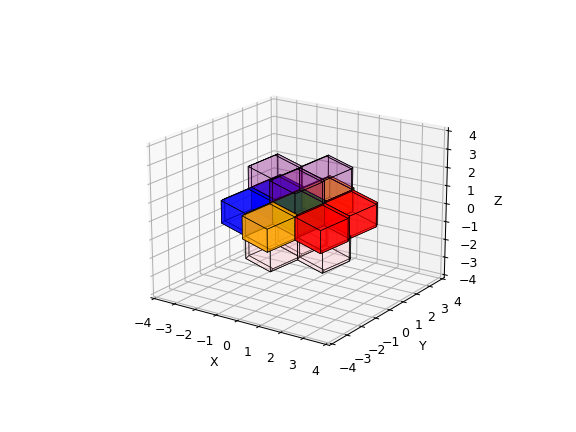

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

In [4]:
positions = [(0,0,0), (0,1,0), (0,-1,0), (1,0,0), (1,1,0), (-1,0,0), (-1,-1,0)]
colors=['green', 'orange', 'orange', 'red', 'red', 'blue', 'blue']
positions.extend([(0,0,1),(0,-1,1),(-1,-1,1)])
colors.extend(['purple', 'purple', 'purple'])

positions.extend([(0,0,-1),(0,1,-1),(1,1,-1)])
colors.extend(['pink', 'pink', 'pink'])

alphas = [0.2 if (len(positions)-i) < 7 else .65 for i in range(len(positions))]


plot_from_grid(positions, colors=colors, alphas=alphas)

<IPython.core.display.Javascript object>


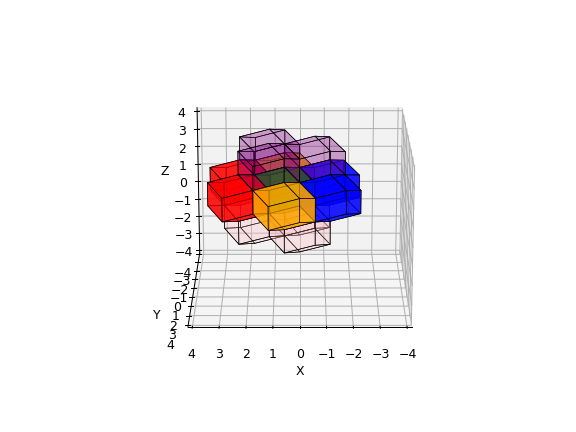

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

In [21]:
positions = [(0,0,0), (0,1,0), (0,-1,0), (1,0,0), (1,1,0), (-1,0,0), (-1,-1,0)]
colors=['green', 'orange', 'orange', 'red', 'red', 'blue', 'blue']
positions.extend([(0,0,1),(0,-1,1),(-1,-1,1)])
colors.extend(['purple', 'purple', 'purple'])

positions.extend([(0,0,-1),(0,1,-1),(1,1,-1)])
colors.extend(['pink', 'pink', 'pink'])

alphas = [0.2 if (len(positions)-i) < 7 else .65 for i in range(len(positions))]

positions = [(pos[0], pos[1], pos[2]+1) for pos in positions]

plot_from_grid(positions, colors=colors, alphas=alphas)

<IPython.core.display.Javascript object>


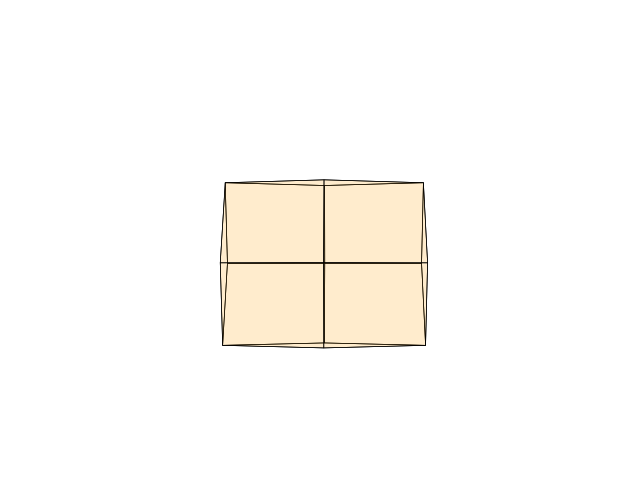

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

In [15]:
positions = [(0, 0, 0), (0,0,1), (0,-1,2), (-1,-2,3)]
positions = [(0, 0, 0)]
# 0.3 square
# 0.18
# 0.06 inbetween
# -0.06
# -0.18 hexagon
plot_from_grid(positions, no_grid=True)

# cells in x: 30
# cells in y: 34
# cells in z: 12
Effective width (x-pos): 30
Effective depth (y-pos): 29.444863728670917
Effective height (z-pos): 14.696938456699067


interactive(children=(IntSlider(value=1, description='tilt', max=3, min=-1), FloatSlider(value=1.0, descriptio…

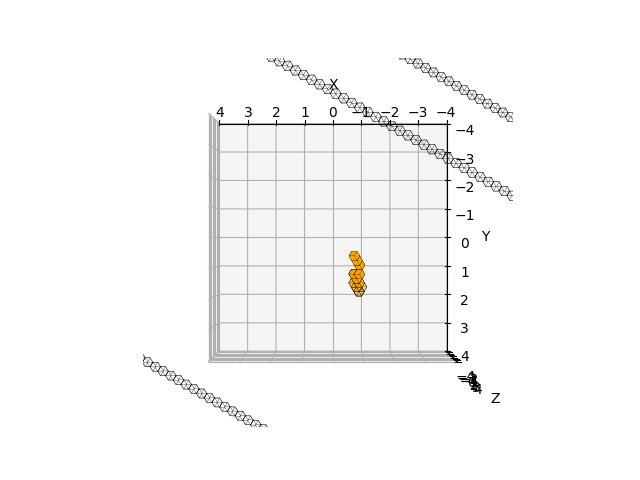

In [104]:
RDG_instance = DBM_RDG(target_height=15, nu=6, threshold=0.001, dim_info=True)
RDG_instance.strike_lightning()
matplotlib.pyplot.close()
plot_lightning_structure(RDG_instance)

In [95]:
matplotlib.pyplot.close()

interactive(children=(IntSlider(value=1, description='tilt', max=3, min=-1), FloatSlider(value=1.0, descriptio…

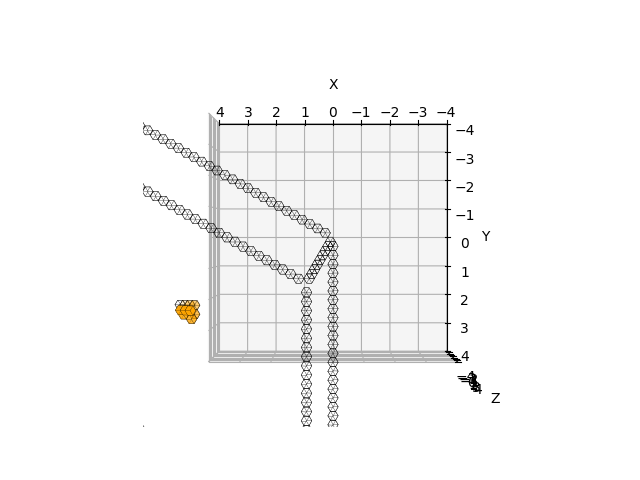

In [72]:
plot_lightning_structure(RDG_instance)

In [39]:
matplotlib.pyplot.close()

## Visualize electric potential, step by step

In [ ]:
RDG_instance_pot = DBM_RDG(target_height=15, nu=6, threshold=0.001, dim_info=True)
strike_locations_list_B = []

# cells in x: 30
# cells in y: 34
# cells in z: 12
Effective width (x-pos): 30
Effective depth (y-pos): 29.444863728670917
Effective height (z-pos): 14.696938456699067


In [5]:
from tqdm import tqdm
for i in tqdm(range(200)):
    RDG_instance_pot = DBM_RDG(target_height=15, nu=6, threshold=0.001, dim_info=False)
    RDG_instance_pot.strike_lightning()
    strike_location = RDG_instance_pot.structure_history[-1]
    strike_locations_list_B.append(strike_location)
    ...
    #RDG_instance_pot.strike_lightning()
    #RDG_instance_pot.update_electric_potential()
    #RDG_instance_pot.update()

  0%|          | 0/200 [00:00<?, ?it/s]


NameError: name 'strike_locations_list_B' is not defined

In [234]:
for i in range(21, 33):
    print(i, sum([pos[0] == i for pos in strike_locations_list_B]))

21 7
22 26
23 92
24 227
25 346
26 463
27 467
28 362
29 226
30 122
31 57
32 17


In [3]:
pos_list = []
alphas = []
fixed_alpha = 0
colors = []

def float_to_hex_color(value, cmap_name='viridis'):
    value = min(0.99999999, max(0, value))
    
    cmap = plt.get_cmap(cmap_name)
    
    rgba = cmap(value)
    
    hex_color = '#{:02x}{:02x}{:02x}'.format(int(rgba[0] * 255), int(rgba[1] * 255), int(rgba[2] * 255))
    
    return hex_color


#max_abs_diff = np.max(abs(RDG_instance_pot.current_potential - RDG_instance_pot.current_potential_old))
#print(max_abs_diff)
min_pot = RDG_instance_pot.potential[0, 0, 2]
max_pot = RDG_instance_pot.potential[0, 0, 2]

z_range = (0, RDG_instance_pot.needed_cell_dim['height'])

for fixed_z in range(z_range[0], z_range[1]):
    for x in range(RDG_instance_pot.dim['width']):
        for y in range(RDG_instance_pot.dim['depth']):
            if (x, y, fixed_z) not in RDG_instance_pot.structure_history or False:
                if RDG_instance_pot.potential[x, y, fixed_z] < min_pot:
                    min_pot = RDG_instance_pot.potential[x, y, fixed_z]
                if RDG_instance_pot.potential[x, y, fixed_z] > max_pot:
                    max_pot = RDG_instance_pot.potential[x, y, fixed_z]


strike_locations_set = set(strike_locations_list_B)
strike_locations_normalized = [strike_locations_list_B.count(strike_location) for strike_location in strike_locations_set]
strike_locations_normalized = np.array(strike_locations_normalized)/np.max(strike_locations_normalized)
strike_locations_normalized_dict = {strike_location: strike_locations_normalized[i] for i, strike_location in enumerate(strike_locations_set)}

for fixed_z in range(z_range[0], z_range[1]):
    for x in range(RDG_instance_pot.needed_cell_dim['width']):
        for y in range(RDG_instance_pot.needed_cell_dim['depth']):
            #pos_list.append((x, y, (10-fixed_z)*1))
            #alphas.append(fixed_alpha)
            #pot = abs(RDG_instance_pot.current_potential[x, y, fixed_z] - RDG_instance_pot.current_potential_old[x, y, fixed_z])/max_abs_diff
            #pot = abs(RDG_instance_pot.current_potential[x, y, fixed_z] - RDG_instance_pot.current_potential_old[x, y, fixed_z])/max_abs_diff
            pot = RDG_instance_pot.potential[x, y, fixed_z]
            pot = (pot - min_pot)/(max_pot-min_pot)
            
            #if (x, y, fixed_z) in RDG_instance_pot.structure_history:
            #    pos_list.append((x, y, (10-fixed_z)*1))
            #    
            #    colors.append('orange')
            #    alphas.append(0.8)

            if (x, y, fixed_z) in strike_locations_set:
                pos_list.append((x, y, (10-fixed_z)*1))

                colors.append(float_to_hex_color(strike_locations_normalized_dict[(x, y, fixed_z)], cmap_name='jet'))
                alphas.append(0.6)
            elif RDG_instance_pot.fixed_grid[x, y, fixed_z] == -1:
                if fixed_z != z_range[0] and fixed_z != z_range[1]-1:
                    pos_list.append((x, y, (10-fixed_z)*1))
                    
                    colors.append('white')
                    alphas.append(0.6)

            if fixed_z == 11 and False:
                pos_list.append((x, y, (10-fixed_z)*1))
                
                colors.append(float_to_hex_color(pot, cmap_name='jet'))
                alphas.append(0.8)
            
            
            #elif (x, y, fixed_z) in RDG_instance_pot.structure_neighbors:
            #    colors.append('yellow')
            #    alphas.append(0.7)
            #elif pot < 0.5:
            #    colors.append('orange')
            #else:
            #    colors.append(float_to_hex_color(pot, cmap_name='jet'))
            #    alphas.append(fixed_alpha)
                

plot_from_grid(pos_list, alphas=alphas, colors=colors, scale=0.15, line_thickness=0.1)

NameError: name 'RDG_instance_pot' is not defined

## Strike location distribution

Datapoints: 2350


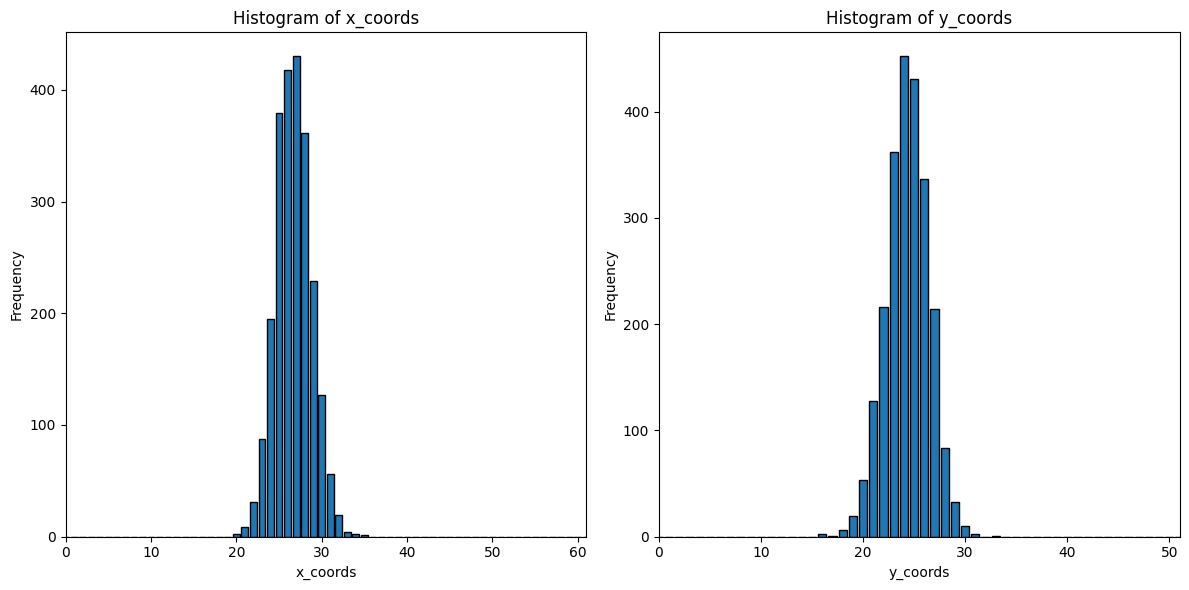

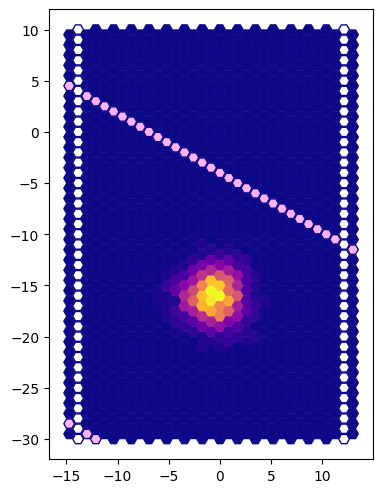

In [88]:
def float_to_rgb_color(value, cmap_name='viridis'):
    value = min(0.9999999999, max(0, value))
    
    cmap = plt.get_cmap(cmap_name)
    
    rgba = cmap(value)
    
    #hex_color = '#{:02x}{:02x}{:02x}'.format(int(rgba[0] * 255), int(rgba[1] * 255), int(rgba[2] * 255))
    return [rgba[0], rgba[1], rgba[2]]

import copy
from hexalattice.hexalattice import *

target_height = 15
width, depth, height = target_height_to_box_dim(target_height)
nu=6
threshold=0.001

filename_strike = f"{__location__}\\data\\RDG_hex_int\\{width}x{depth}x{height}_{nu}_{threshold}_strikedata.txt"
strike_file = open(filename_strike,'r')
strike_data_str = strike_file.read()
strike_data_str = strike_data_str.split('#')[:-1]

width_max = width*2+1
depth_max = depth*3//2
strike_data = np.zeros((width_max, depth_max))
print("Datapoints:", len(strike_data_str))

x_coords = []
y_coords = []

for point in strike_data_str:
    point = point.split(',')
    x_coord = point[0]
    y_coord = point[1]
    x_coord = x_coord.strip()
    x_coord = x_coord.strip('(')
    y_coord = y_coord.strip()
    y_coord = y_coord.strip(')')
    strike_data[int(x_coord), int(y_coord)] += 1
    x_coords.append(int(x_coord))
    y_coords.append(int(y_coord))

strike_data /= np.max(strike_data)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(range(width_max+1), [x_coords.count(i) for i in range(width_max+1)], edgecolor='black')
plt.title('Histogram of x_coords')
plt.xlabel('x_coords')
plt.ylabel('Frequency')
plt.xlim(xmin=0, xmax = width_max)

plt.subplot(1, 2, 2)
plt.bar(range(depth_max+1), [y_coords.count(i) for i in range(depth_max+1)], edgecolor='black')
plt.title('Histogram of y_coords')
plt.xlabel('y_coords')
plt.ylabel('Frequency')
plt.xlim(xmin=0, xmax = depth_max)

plt.tight_layout()
plt.show()

hex_centers, _ = create_hex_grid(nx=width_max,
                                     ny=depth_max,
                                     do_plot=False)
x_hex_coords = hex_centers[:, 0]
x_hex_coords = np.array([val - i//(width_max) + (i*1)//(2*width_max) for i, val in enumerate(x_hex_coords)])
y_hex_coords = hex_centers[:, 1]


colors = np.array([float_to_rgb_color(strike_data[x_pos, y_pos], cmap_name='plasma') for y_pos in range(depth_max) for x_pos in range(width_max)])
edge_colors = copy.deepcopy(colors)

new_edge_colors = []
new_colors = []
new_x_hex_coords = []
new_y_hex_coords = []

left_boundary = 8
right_boundary = 40
top_boundary = -30
bottom_boundary = 10
for x_pos in range(width_max):
    for y_pos in range(depth_max):
        if y_pos < left_boundary or y_pos > right_boundary or \
            x_hex_coords[x_pos + y_pos * width_max] < top_boundary or \
            x_hex_coords[x_pos + y_pos * width_max] > bottom_boundary:
            continue
        new_edge_colors.append(edge_colors[x_pos + y_pos * width_max])
        if y_pos == 9 or y_pos == 39:
            new_colors.append([1,1,1])
        elif x_pos == 6 or x_pos == 39:
            new_colors.append([1,.7,1])
        else:
            new_colors.append(colors[x_pos + y_pos * width_max])
        new_x_hex_coords.append(x_hex_coords[x_pos + y_pos * width_max])
        new_y_hex_coords.append(y_hex_coords[y_pos + y_pos * width_max])

new_edge_colors = np.array(new_edge_colors)
new_colors = np.array(new_colors)
new_x_hex_coords = np.array(new_x_hex_coords)
new_y_hex_coords = np.array(new_y_hex_coords)



plot_single_lattice_custom_colors(new_y_hex_coords, new_x_hex_coords,
                                      face_color=new_colors,
                                      edge_color=new_edge_colors,
                                      min_diam=0.99,
                                      plotting_gap=0.08,
                                      rotate_deg=30)
plt.show()

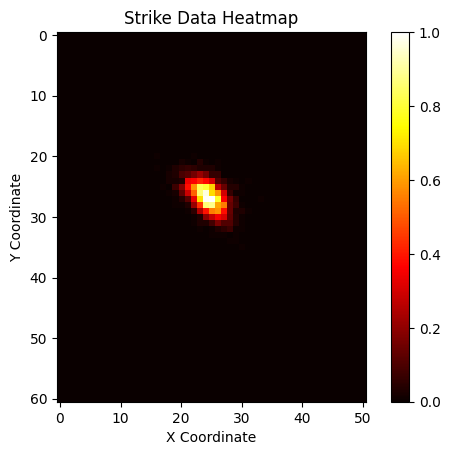

In [56]:
plt.close()

plt.imshow(strike_data, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Strike Data Heatmap')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

In [ ]:
plt.close()
matplotlib.pyplot.close()

## Unstructured code and visualizations

<IPython.core.display.Javascript object>


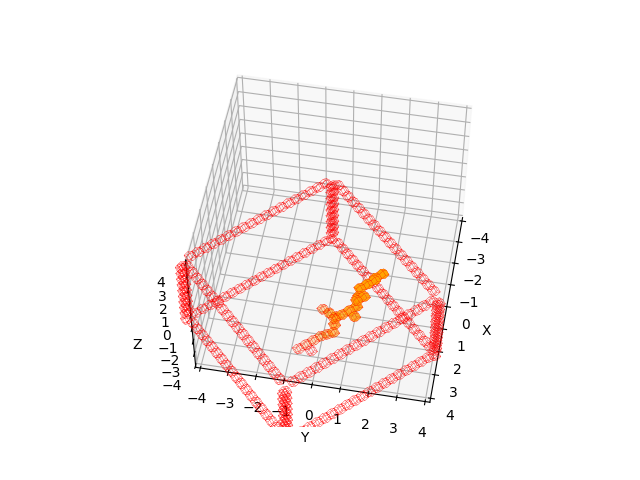

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

In [ ]:
alphas = list(np.linspace(1, 0, len(RDG_instance_pot.structure_history)))

pos_list = []
#pos_list.extend([(pos[1], pos[2], RDG_instance.dim['width']-pos[0]) for pos in RDG_instance.structure_history])
pos_list.extend([(pos[0], pos[1], RDG_instance_pot.dim['height']-1-pos[2])for pos in RDG_instance_pot.structure_history])
#pos_list.extend([(i, 12, 12) for i in range(20)])



# Plot the edges of the boundary
for x in range(1, RDG_instance_pot.dim['depth']):
    pos_list.append((x, 0, 0)) 
    pos_list.append((x, RDG_instance_pot.dim['height'], 0)) 
    pos_list.append((x, 0, RDG_instance_pot.dim['width']))
    pos_list.append((x, RDG_instance_pot.dim['height'], RDG_instance_pot.dim['width']))
    for _ in range(4):
        alphas.append(0)
        
for y in range(1, RDG_instance_pot.dim['height']):
    pos_list.append((0, y, 0)) 
    pos_list.append((RDG_instance_pot.dim['depth'], y, 0)) 
    pos_list.append((0, y, RDG_instance_pot.dim['width']))
    pos_list.append((RDG_instance_pot.dim['depth'], y, RDG_instance_pot.dim['width']))
    for _ in range(4):
        alphas.append(0)
        
for z in range(1, RDG_instance_pot.dim['width']):
    pos_list.append((0, 0, z))
    pos_list.append((RDG_instance_pot.dim['depth'], 0, z)) 
    pos_list.append((0, RDG_instance_pot.dim['height'], z))
    pos_list.append((RDG_instance_pot.dim['depth'], RDG_instance_pot.dim['height'], z))
    for _ in range(4):
        alphas.append(0)

plot_from_grid(pos_list, alphas=alphas, scale=0.15, line_thickness=0.25)

<IPython.core.display.Javascript object>


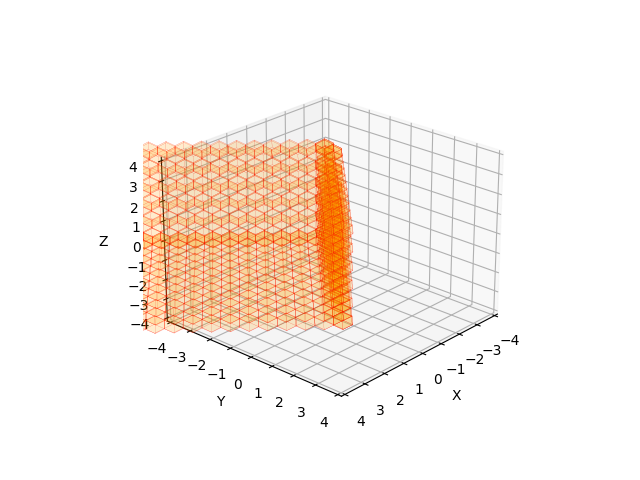

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

In [10]:
alphas = list(np.linspace(1, 0, len(RDG_instance.structure_history)))

pos_list = []
pos_list.extend([(0,0,i) for i in range(12)])
for x in range(12):
    for y in range(12):
        pos_list.append((x, y, 0)) 
        pos_list.append((x, 0, y)) 
        pos_list.append((0, x, y))
        alphas.append(0)
        alphas.append(0)
        alphas.append(0)

plot_from_grid(pos_list, alphas=alphas, scale=0.3, line_thickness=0.1)

# ---------------------------------

<IPython.core.display.Javascript object>


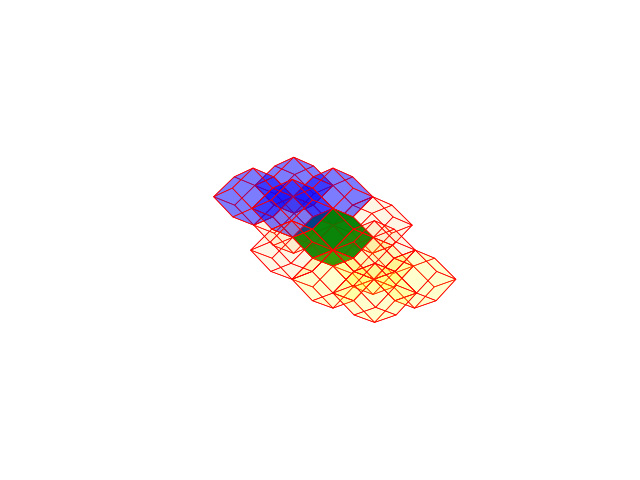

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

In [4]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt


def plot_from_grid(pos_list, colors, alphas):
    x = np.linspace(0, 2 * np.pi)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    for i, pos in enumerate(pos_list):
        plot_rhombic_dodecahedron(ax, pos, colors[i], alpha=alphas[i])

    plt.axis('off')

    def update(tilt = 0.2, jaw=1.0):
        ax.view_init(elev=tilt*90, azim=jaw*90)
        fig.canvas.draw_idle()

    interact(update);


pos_list = []
for i in range(5):
    pos_list.append((0,0,i))

for i in range(5):
    pos_list.append((0,i,4))

for i in range(5):
    pos_list.append((i,4,4))

#plot_from_grid(pos_list)

center = (0,0,0)
pos_list = []
colors = []
alphas = []
pos_list.append(center)
colors.append('green')
alphas.append(0.8)
for i, neighbor in enumerate([(1, 0, 0), (0, 1, 0), (-1, 0, 0), (0,-1, 0), 
                          (0, -1, 1), (1, -1, 1), (0, 0, 1), (1, 0, 1),
                          (0, 1, -1), (-1, 1, -1), (0, 0, -1), (-1, 0, -1)]):

    pos_list.append((center[0]+neighbor[0],center[1]+neighbor[1],center[2]+neighbor[2]))
    if i > 3 and i < 8:
        colors.append('blue')
        alphas.append(0.3)
    elif i >= 8:
        colors.append('yellow')
        alphas.append(0.1)
    else:
        colors.append('orange')
        alphas.append(0.05)
#pos_list.append((1,0,0))
#pos_list.append((0,1,0))
#pos_list.append((-1,0,0))
#pos_list.append((0,-1,0))
plot_from_grid(pos_list, colors, alphas)


<IPython.core.display.Javascript object>


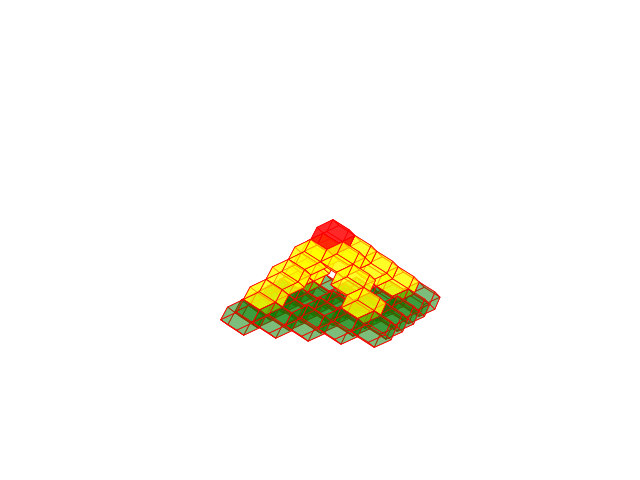

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

In [41]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt


def plot_from_grid(pos_list, colors, alphas, scale):
    x = np.linspace(0, 2 * np.pi)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    for i, pos in enumerate(pos_list):
        plot_rhombic_dodecahedron(ax, pos, colors[i], alpha=alphas[i], scale=scale)

    plt.axis('off')

    def update(tilt = 0.2, jaw=1.0):
        ax.view_init(elev=tilt*90, azim=jaw*90)
        fig.canvas.draw_idle()

    interact(update);


pos_list = [(0,0,0)]
for i in range(1,4):
    pos_list.append((0,0,-i))
    pos_list.append((0,i,-i))
    pos_list.append((i,0,-i))
    pos_list.append((i,i,-i))
    

#pos_list.append((0,0,-4))
#pos_list.append((0,4,-4))
#pos_list.append((4,0,-4))
#pos_list.append((4,4,-4))

for x in range(5):
    for y in range(5):
        pos_list.append((y,x,-4))
        

#(0, -1, 1), (1, -1, 1), (0, 0, 1), (1, 0, 1),
#(0, 1, -1), (-1, 1, -1), (0, 0, -1), (-1, 0, -1)
  
colors = ['red']
colors.extend(['yellow' for _ in range(4*3)])
colors.extend(['green' for _ in range(25)])
alphas = [0.6 for _ in range(4*3+1)]
alphas.extend([0.3 for _ in range(25)])

plot_from_grid(pos_list, colors, alphas, scale=0.6)


<IPython.core.display.Javascript object>


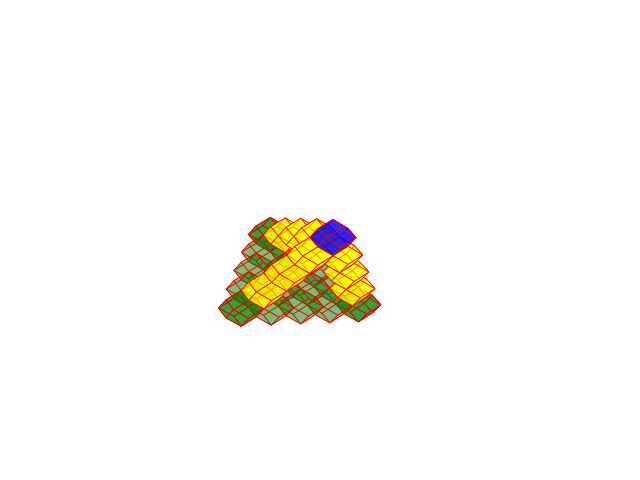

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

In [62]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt


def plot_from_grid(pos_list, colors, alphas, scale):
    x = np.linspace(0, 2 * np.pi)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    for i, pos in enumerate(pos_list):
        plot_rhombic_dodecahedron(ax, pos, colors[i], alpha=alphas[i], scale=scale)

    plt.axis('off')

    def update(tilt = 0.2, jaw=1.0):
        ax.view_init(elev=tilt*90, azim=jaw*90)
        fig.canvas.draw_idle()

    interact(update);


pos_list = [(0,0,0)]
pos_list.append((0,0,-1))
pos_list.append((0,-1,0))
pos_list.append((1,0,-1))

for i in range(1,4):
    pos_list.append((0,0,-i))
    pos_list.append((0,-i,0))
    pos_list.append((i,0,-i))
    


for j in range(5):
    for i in range(j, 5):
        pos_list.append((j,-i+j,-4+i-j))
    

#pos_list.append((0,4,-4))
#pos_list.append((4,0,-4))
#pos_list.append((4,4,-4))

        

#(0, -1, 1), (1, -1, 1), (0, 0, 1), (1, 0, 1),
#(0, 1, -1), (-1, 1, -1), (0, 0, -1), (-1, 0, -1)
  
colors = ['blue']
colors.extend(['yellow' for _ in range(4*3)])
colors.extend(['green' for _ in range(25)])
alphas = [0.6 for _ in range(4*3+1)]
alphas.extend([0.3 for _ in range(25)])

plot_from_grid(pos_list, colors, alphas, scale=0.6)


[(0, 0, -2), (0, 0, -1), (0, 0, 0), (0, 0, 1), (0, -1, 2)]
[(0, 0, -2), (0, 0, -1), (0, 0, 0), (0, 0, 1), (0, -1, 2), (1, -1, 2)]
[(0, 0, -2), (0, 0, -1), (0, 0, 0), (0, 0, 1), (0, -1, 2), (1, -1, 2), (0, 0, 2)]
[(0, 0, -2), (0, 0, -1), (0, 0, 0), (0, 0, 1), (0, -1, 2), (1, -1, 2), (0, 0, 2), (1, 0, 2)]


<IPython.core.display.Javascript object>


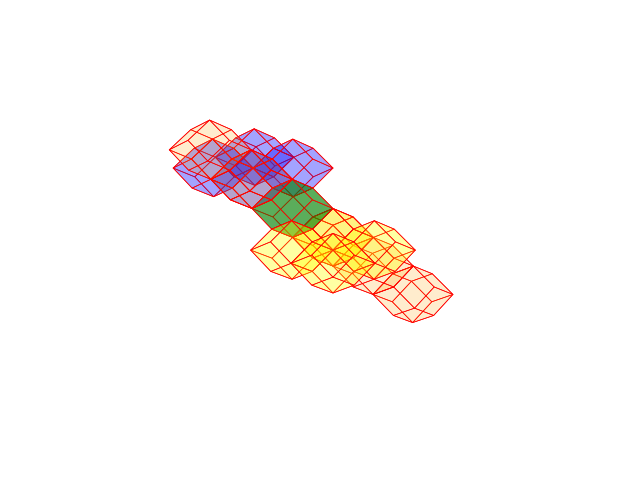

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

In [12]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt


def plot_from_grid(pos_list, colors, alphas):
    x = np.linspace(0, 2 * np.pi)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    for i, pos in enumerate(pos_list):
        plot_rhombic_dodecahedron(ax, pos, colors[i], alpha=alphas[i])

    plt.axis('off')

    def update(tilt = 0.2, jaw=1.0):
        ax.view_init(elev=tilt*90, azim=jaw*90)
        fig.canvas.draw_idle()

    interact(update);


pos_list = []
for i in range(5):
    pos_list.append((0,0,i))

for i in range(5):
    pos_list.append((0,i,4))

for i in range(5):
    pos_list.append((i,4,4))

#plot_from_grid(pos_list)

center = (0,0,-3)
pos_list = []
colors = []
alphas = []
for i in range(-2,4):

    pos_list.append((0,0,i))
    if i == 1:
        colors.append('green')
        alphas.append(0.4)
        
        for above_neigh in [(0, -1, 1), (1, -1, 1), (0, 0, 1), (1, 0, 1)]:
            pos_list.append((above_neigh[0],above_neigh[1],above_neigh[2]+i))
            print(pos_list)
            colors.append('blue')
            alphas.append(0.2)
            
        for below_neigh in [(0, 1, -1), (-1, 1, -1), (0, 0, -1), (-1, 0, -1)]:
            pos_list.append((below_neigh[0],below_neigh[1],below_neigh[2]+i))
            colors.append('yellow')
            alphas.append(0.2)
    else:
        colors.append('orange')
        alphas.append(0.1)
        
#pos_list.append((1,0,0))
#pos_list.append((0,1,0))
#pos_list.append((-1,0,0))
#pos_list.append((0,-1,0))
plot_from_grid(pos_list, colors, alphas)


<IPython.core.display.Javascript object>


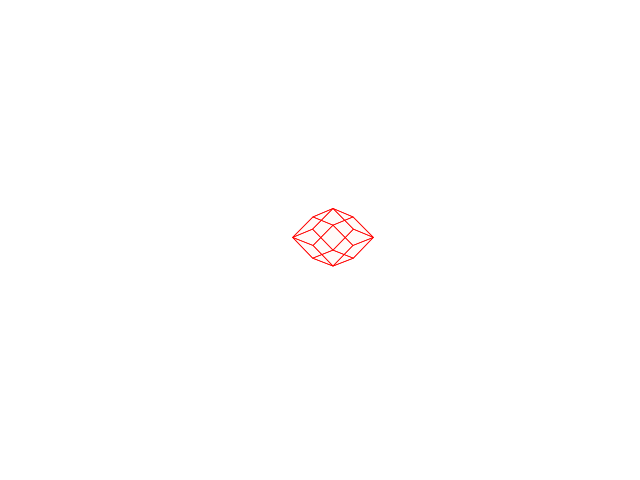

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

<IPython.core.display.Javascript object>


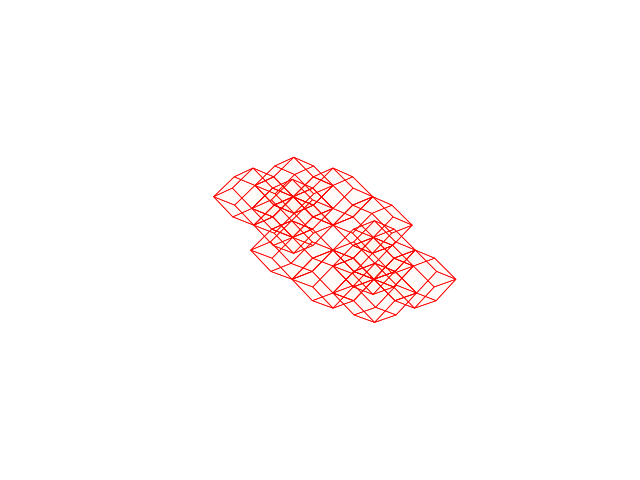

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

<IPython.core.display.Javascript object>


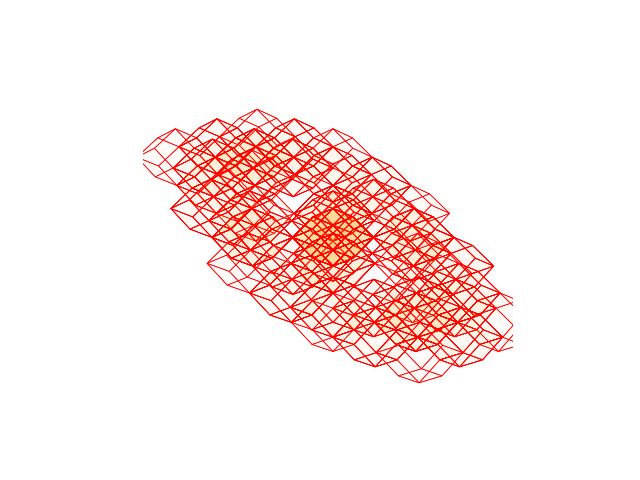

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

<IPython.core.display.Javascript object>


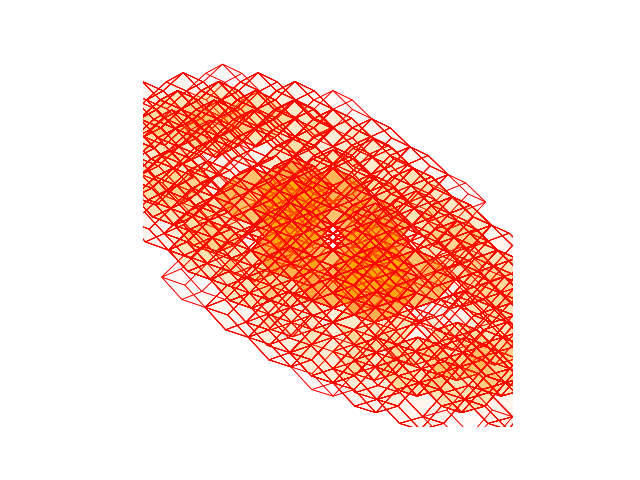

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

<IPython.core.display.Javascript object>


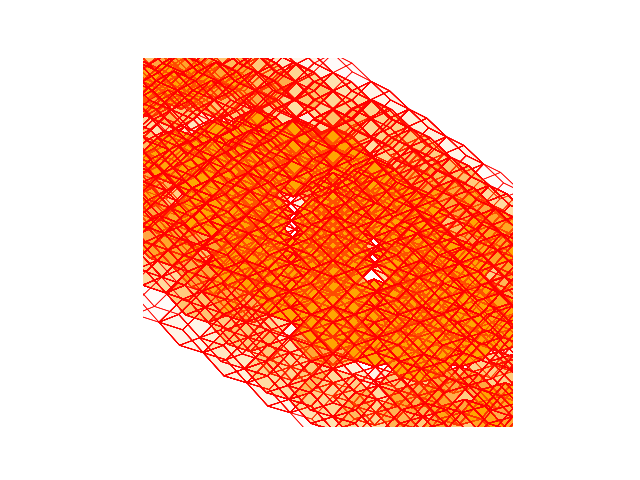

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

In [13]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt


def plot_from_grid(pos_list, colors, alphas):
    x = np.linspace(0, 2 * np.pi)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    for i, pos in enumerate(pos_list):
        plot_rhombic_dodecahedron(ax, pos, colors[i], alpha=alphas[i])

    plt.axis('off')

    def update(tilt = 0.2, jaw=1.0):
        ax.view_init(elev=tilt*90, azim=jaw*90)
        fig.canvas.draw_idle()

    interact(update);


neighbors = [(1, 0, 0), (0, 1, 0), (-1, 0, 0), (0,-1, 0), 
            (0, -1, 1), (1, -1, 1), (0, 0, 1), (1, 0, 1),
            (0, 1, -1), (-1, 1, -1), (0, 0, -1), (-1, 0, -1)]

center = (0,0,0)
pos_list = [center]
colors = ['orange']
alphas = [0.01]
plot_from_grid(pos_list, colors, alphas)

for _ in range(4):
    colors = []
    alphas = []
    old_pos_list = []
    old_pos_list.extend(pos_list[:])
    pos_list = []
    for pos in old_pos_list:
        for neighbor in neighbors:
            if (neighbor[0]+pos[0], neighbor[1]+pos[1], neighbor[2]+pos[2]) not in old_pos_list:
                pos_list.append((neighbor[0]+pos[0], neighbor[1]+pos[1], neighbor[2]+pos[2]))
                colors.append('orange')
                alphas.append(0.01)
    plot_from_grid(pos_list, colors, alphas)


In [7]:
import numpy as np
grid = np.zeros((10,10,10))

def directly_up(pos):
    if pos[2] % 2 == 0:
        return (pos[0], pos[1], pos[2]+1)
    else:
        return (pos[0]-1, pos[1]-1, pos[2]+1)

def upwards_neighbors(pos):
    neighbors = []
    if pos[2] % 2 == 0:
        neighbors.append((pos[0], pos[1], pos[2]+1))
        neighbors.append((pos[0]-1, pos[1], pos[2]+1))
        neighbors.append((pos[0], pos[1]-1, pos[2]+1))
        neighbors.append((pos[0]-1, pos[1]-1, pos[2]+1))
    else:
        neighbors.append((pos[0], pos[1], pos[2]+1))
        neighbors.append((pos[0]+1, pos[1], pos[2]+1))
        neighbors.append((pos[0], pos[1]+1, pos[2]+1))
        neighbors.append((pos[0]+1, pos[1]+1, pos[2]+1))
    return neighbors

def below_neighbors(pos):
    neighbors = []
    if pos[2] % 2 == 0:
        neighbors.append((pos[0], pos[1], pos[2]-1))
        neighbors.append((pos[0]-1, pos[1], pos[2]-1))
        neighbors.append((pos[0], pos[1]-1, pos[2]-1))
        neighbors.append((pos[0]-1, pos[1]-1, pos[2]-1))
    else:
        neighbors.append((pos[0], pos[1], pos[2]-1))
        neighbors.append((pos[0]+1, pos[1], pos[2]-1))
        neighbors.append((pos[0], pos[1]+1, pos[2]-1))
        neighbors.append((pos[0]+1, pos[1]+1, pos[2]-1))
    return neighbors
    



# Create subplots for each angle
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection='3d')


#plot_rhombic_dodecahedron(ax, pos=(0,0,1), color='green')
#plot_rhombic_dodecahedron(ax, pos=(0,0,-1), color='orange')
#plot_rhombic_dodecahedron(ax, pos=(1,0,0), color='yellow')
#plot_rhombic_dodecahedron(ax, pos=(-1,0,0), color='yellow')
plot_rhombic_dodecahedron(ax, pos=(0,2,0), color='orange')

plot_rhombic_dodecahedron(ax, pos=(0,1,0), color='orange')
#plot_rhombic_dodecahedron(ax, pos=(1,1,0), color='white')
#plot_rhombic_dodecahedron(ax, pos=(0,1,1), color='white')
#plot_rhombic_dodecahedron(ax, pos=(1,1,1), color='white')
plot_rhombic_dodecahedron(ax)

#plot_rhombic_dodecahedron(ax, pos=(0,-1,-1), color='yellow')
#plot_rhombic_dodecahedron(ax, pos=(-1,-1,0), color='yellow')
#plot_rhombic_dodecahedron(ax, pos=(0,-1,0), color='yellow')

#plot_rhombic_dodecahedron(ax, pos=(1,-2,0), color='white')
#plot_rhombic_dodecahedron(ax, pos=(0,-2,1), color='white')
#plot_rhombic_dodecahedron(ax, pos=(1,-2,1), color='white')


plot_rhombic_dodecahedron(ax, pos=(1,0,0), color='pink')
plot_rhombic_dodecahedron(ax, pos=(2,0,0), color='pink')

current_pos = (0,0,1)
for i in range(5):
    if i % 2 == 1:
        alpha = 0
    else:
        alpha = 0.5
    plot_rhombic_dodecahedron(ax, pos=gridpos_to_plot_pos((0,0,i)), color='yellow', alpha=alpha)
    #current_pos = directly_up(current_pos)
    #plot_rhombic_dodecahedron(ax, pos=current_pos, color='yellow')

#this_pos = (0,0,3)
#up_neighbors = upwards_neighbors(this_pos)
#for pos in up_neighbors:
    #plot_rhombic_dodecahedron(ax, pos=pos, color='pink')
    

#plot_rhombic_dodecahedron(ax, pos=(0,0,1), color='yellow')
#plot_rhombic_dodecahedron(ax, pos=(0,-1,1), color='yellow', alpha=0.05)
#plot_rhombic_dodecahedron(ax, pos=(-1,0,1), color='yellow', alpha=0.05)
#plot_rhombic_dodecahedron(ax, pos=(-1,-1,1), color='yellow', alpha=0.05)

#plot_rhombic_dodecahedron(ax, pos=(-1,-1,2), color='green')
#plot_rhombic_dodecahedron(ax, pos=(-1,-1,3))

center = (2,2,2)
plot_rhombic_dodecahedron(ax, pos=gridpos_to_plot_pos(center), color='yellow')
above = (2,2,2)
plot_rhombic_dodecahedron(ax, pos=gridpos_to_plot_pos(above), color='red')
#above = (2,3,2)
#plot_rhombic_dodecahedron(ax, pos=gridpos_to_plot_pos(above), color='pink')
#above = (3,2,2)
#plot_rhombic_dodecahedron(ax, pos=gridpos_to_plot_pos(above), color='pink')
#above = (3,3,2)
#plot_rhombic_dodecahedron(ax, pos=gridpos_to_plot_pos(above), color='pink')

up_neighbors = upwards_neighbors(center)
for pos in up_neighbors:
    plot_rhombic_dodecahedron(ax, pos=gridpos_to_plot_pos(pos), color='pink')
below_neighbors = below_neighbors(center)
for pos in below_neighbors:
    plot_rhombic_dodecahedron(ax, pos=gridpos_to_plot_pos(pos), color='yellow')


plt.show()

<IPython.core.display.Javascript object>